In [347]:
## Libraries
from sktime.classification.kernel_based import RocketClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.rocket import Rocket
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [349]:
alcohol_data=pd.read_csv("non_alc_curves.csv")

Helpers to reshape data

In [5]:
### Function to check and trim data for samples that are too long/short
def check_and_trim(df):
    # Define the desired size per group
    desired_size = 3600

    # Create an empty DataFrame to hold the trimmed data
    trimmed_df = pd.DataFrame()

    # Group the dataframe by 'Full_Sample_ID' and iterate over the groups
    for full_sample_id, group in df.groupby('Full_Sample_ID'):
        # If the size of the group is larger than the desired size, take the first 'desired_size' rows
        if len(group) > desired_size:
            group = group.iloc[:desired_size]
        # Append the group to the trimmed dataframe
        trimmed_df = pd.concat([trimmed_df, group], ignore_index=True)

    return trimmed_df

In [209]:
## Get file names
root = '.'
# files = os.listdir(root) ## For everything
files = ['non_alc_curves.csv'] 

## Set up lists
pred_vars = ['Full_Sample_ID', 'Brake','Accel', 'Lat_Pos', 'Speed', 'Heading', 'Wheel_Rate']
x_vars = ['Brake','Accel', 'Lat_Pos', 'Speed', 'Heading', 'Wheel_Rate']
y_vars = ['Target','Full_Sample_ID']
# x_vars = ['Lat_Pos', 'Speed']  ## Reduced set of X-vars
# pred_vars = ['Full_Sample_ID', 'Lat_Pos', 'Speed'] ## Reduced set of X-vars
split_names = ['split1','split2','split3','split4','split5','split6','split7','split8','split9','split10']

###  Outer Loop through diff experiments
for cur_file in files:
    data = pd.read_csv(root + '/' + cur_file)
    data = data.rename(columns={'CFS.Brake.Pedal.Force': 'Brake', 
                         'CFS.Accelerator.Pedal.Position': 'Accel', 
                         'SCC.Lane.Deviation.2': 'Lat_Pos',
                        'VDS.Veh.Heading.Fixed': 'Heading',
                        'VDS.Veh.Speed': 'Speed',
                        'CFS.Steering.Wheel.Angle': 'Wheel_Angle',
                        'CFS.Steering.Wheel.Angle.Rate': 'Wheel_Rate'})
    
    ## File where where results will be stored
    res_file = cur_file.strip('.csv') + '_rawpreds.csv'

    ### Inner loop through diff validation sets
    ict_res_df = pd.DataFrame(columns = ['val_split','sample_ID','pos_class_proba','target'])
    for sp in split_names:
        train_y = data.loc[data[sp] == 'train'][y_vars]
        train_X = check_and_trim(data.loc[data[sp] == 'train'][pred_vars]).iloc[1::6, :]
        # train_X = check_and_trim(data.loc[data[sp] == 'train'][pred_vars])
        test_y = data.loc[data[sp] == 'val'][y_vars]
        # test_X = check_and_trim(data.loc[data[sp] == 'val'][pred_vars])
        test_X = check_and_trim(data.loc[data[sp] == 'val'][pred_vars]).iloc[1::6, :]
        
        ## Reformat data in 3-d arrays suitable for inception time/rocket
        train_X_array = np.zeros(shape = (train_X['Full_Sample_ID'].nunique(), len(pred_vars) - 1, 
                                          int(train_X.shape[0]/train_X['Full_Sample_ID'].nunique())))
        train_y_small = np.zeros(shape = (train_X['Full_Sample_ID'].nunique()))

        test_X_array = np.zeros(shape = (test_X['Full_Sample_ID'].nunique(), len(pred_vars) - 1, 
                                         int(test_X.shape[0]/test_X['Full_Sample_ID'].nunique())))
        test_y_small = np.zeros(shape = (test_X['Full_Sample_ID'].nunique()))

        id_list = train_X['Full_Sample_ID'].unique()
        i = 0
        for cur_id in id_list:
            ji = 0
            for j in x_vars:
                train_X_array[i,ji,:] = train_X.loc[train_X['Full_Sample_ID'] == cur_id][j]
                ji=ji+1
            train_y_small[i] = train_y.loc[train_y['Full_Sample_ID'] == cur_id]['Target'].unique()
            i=i+1

        test_id_list = test_X['Full_Sample_ID'].unique()
        i = 0
        for cur_id in test_id_list:
            ji = 0
            for j in x_vars:
                test_X_array[i,ji,:] = test_X.loc[test_X['Full_Sample_ID'] == cur_id][j]
                ji=ji+1
            test_y_small[i] = test_y.loc[test_y['Full_Sample_ID'] == cur_id]['Target'].unique()
            i=i+1

In [30]:
train_X_array.shape

(75, 6, 600)

In [28]:
alcohol_data.shape

(403200, 24)

In [210]:
param_grid = {
    'num_kernels': [10000, 20000, 30000],
    "random_state":["None","int"]
}


rocket = Rocket()

grid_search = GridSearchCV(estimator=rocket, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_X_array)

best_params = grid_search.best_params_
best_rocket = Rocket(**best_params)
best_rocket_fit=best_rocket.fit(train_X_array)
X_train_transform = best_rocket_fit.transform(train_X_array)

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:988: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 975, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


Using ridge to predict final targets

In [211]:
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_transform, train_y_small)

X_test_transform = best_rocket.transform(test_X_array)
classifier.score(X_test_transform, test_y_small)

coeff=[]
feature=[]

for i in range(classifier.coef_.size):
    coeff.append(classifier.coef_[0,i])
    feature.append(i+1)


In [246]:
    # //dataset with all ccoefficeints from ridge
ridge_coefficients=pd.DataFrame(data={"coeff":coeff,"Kernel":feature},index=range(1,20001))
ridge_coefficients.index.names=['feature']
ridge_coefficients["Kernel"]=np.ceil(ridge_coefficients["Kernel"]/2)
#sort coefficeints by highest magnitude anbd then returns the kernels from the top 10 features
# ridge_coefficients.sort_values(by="coeff",key=abs,ascending=False).head(n=10)
top1=ridge_coefficients.sort_values(by="coeff",key=abs,ascending=False)["coeff"].iloc[0]
ridge_coefficients["Importance"]=np.abs(ridge_coefficients["coeff"])/np.abs(top1)
feature_index=ridge_coefficients.sort_values(by="coeff",key=abs,ascending=False).head(n=50)["Kernel"]

# assign the max importance score of a givben feature to the entire kernel
max_importance_per_kernel = ridge_coefficients.groupby('Kernel')['Importance'].max()
max_importance_df = max_importance_per_kernel.reset_index()
max_importance_df.columns = ['Kernel', 'Max_Importance']

In [247]:
max_importance_df



,Kernel,Max_Importance
0,1.0,0.322709
1,2.0,0.009330
2,3.0,0.093652
3,4.0,0.144857
4,5.0,0.092331
...,...,...
9995,9996.0,0.233580
9996,9997.0,0.088040
9997,9998.0,0.128443
9998,9999.0,0.106800


In [248]:
max_importance_df

,Kernel,Max_Importance
0,1.0,0.322709
1,2.0,0.009330
2,3.0,0.093652
3,4.0,0.144857
4,5.0,0.092331
...,...,...
9995,9996.0,0.233580
9996,9997.0,0.088040
9997,9998.0,0.128443
9998,9999.0,0.106800


Saliency map of the actual kernels

In [214]:
train_X_array.shape
# 75 vectors (for each sample)
    # each vector has 2 subvectors the two variables
    #600 observation (time series 600 observation for the two variables)

(75, 6, 600)

In [52]:
train_X_array[1][1].shape

(600,)

In [36]:
train_X_array[3]

array([[-1.16941643, -1.22582221, -1.28568649, ..., -0.26900891,
        -0.34736151, -0.40658009],
       [65.02285004, 65.01714325, 65.01361847, ..., 58.18973923,
        58.41556549, 58.64117813]])

In [86]:
best_rocket_fit.kernels[6]

array([1, 0, 0, ..., 1, 0, 1], dtype=int32)

In [215]:
# Assuming kernelss is a tuple containing the generated kernels
start_index=0
end_index=0
for i in range(best_rocket_fit.num_kernels):
    lengths = best_rocket_fit.kernels[1][i]  
    end_index+=lengths
    weights = best_rocket_fit.kernels[0][start_index:end_index]  
    biases = best_rocket_fit.kernels[2][i]  
    dilations = best_rocket_fit.kernels[3][i]  
    paddings = best_rocket_fit.kernels[4][i] 
    num_channel_indices = best_rocket_fit.kernels[5][i]  
    channel_indices = best_rocket_fit.kernels[6][
        sum(best_rocket_fit.kernels[5][:i]) : sum(best_rocket_fit.kernels[5][: i + 1])
    ]  # channel indices for the i-th kernel
    start_index=end_index
    print(f"Kernel {i + 1}:")
    print(f"Weights: {weights}")
    print(f"Length: {lengths}")
    print(f"Bias: {biases}")
    print(f"Dilation: {dilations}")
    print(f"Padding: {paddings}")
    print(f"Number of Channel Indices: {num_channel_indices}")
    print(f"Channel Indices: {channel_indices}")
    print()


Kernel 1:
Weights: [-1.9689035  -0.4048918   1.1696129   1.3569411   0.9746572  -0.63451636
 -0.4928993 ]
Length: 7
Bias: 0.37947165966033936
Dilation: 7
Padding: 21
Number of Channel Indices: 3
Channel Indices: [5 4 3]

Kernel 2:
Weights: [-0.3883368  -0.9252036   0.42221978  0.6516906  -0.68505836  0.33834597
  0.58634245]
Length: 7
Bias: 0.06490179896354675
Dilation: 15
Padding: 45
Number of Channel Indices: 4
Channel Indices: [2 5 1 3]

Kernel 3:
Weights: [-0.24714291 -0.08818283  0.82468635 -0.6754699   0.09270673 -0.11183595
  0.20523843 -0.71956193  1.1007264 ]
Length: 9
Bias: -0.17851419746875763
Dilation: 8
Padding: 32
Number of Channel Indices: 3
Channel Indices: [3 0 1]

Kernel 4:
Weights: [ 0.23417981  0.850247   -0.40140894 -1.0196421  -0.04454026 -0.06327741
  0.25577715]
Length: 7
Bias: 0.018580587580800056
Dilation: 18
Padding: 54
Number of Channel Indices: 5
Channel Indices: [2 0 1 5 3]

Kernel 5:
Weights: [-0.32142085  0.29928553  0.5708461   0.1765254  -0.91773593  0

KeyboardInterrupt: 

Saving kernel info

In [216]:
# Assuming kernelss is a tuple containing the generated kernels
kernel_info = []

start_index = 0
end_index = 0
for i in range(best_rocket_fit.num_kernels):
    
    lengths = best_rocket_fit.kernels[1][i]  
    end_index += lengths
    weights = best_rocket_fit.kernels[0][start_index:end_index]  
    biases = best_rocket_fit.kernels[2][i]  
    dilations = best_rocket_fit.kernels[3][i]  
    paddings = best_rocket_fit.kernels[4][i] 
    num_channel_indices = best_rocket_fit.kernels[5][i]  
    channel_indices = best_rocket_fit.kernels[6][sum(best_rocket_fit.kernels[5][:i]):
                                                  sum(best_rocket_fit.kernels[5][: i + 1])]  
    
    kernel_dict = {
        "Kernel": i + 1,
        "Weights": weights.tolist(),
        "Length": lengths,
        "Bias": biases,
        "Dilation": dilations,
        "Padding": paddings,
        "Num_Channel_Indices": num_channel_indices,
        "Channel_Indices": channel_indices.tolist()
    }
    
    kernel_info.append(kernel_dict)
    start_index = end_index


In [238]:
kernel_info_df = pd.DataFrame(kernel_info)

In [239]:
kernel_info_df

,Kernel,Weights,Length,Bias,Dilation,Padding,Num_Channel_Indices,Channel_Indices
0,1,"[-1.9689035415649414, -0.4048917889595032, 1.1...",7,0.379472,7,21,3,"[5, 4, 3]"
1,2,"[-0.38833680748939514, -0.9252036213874817, 0....",7,0.064902,15,45,4,"[2, 5, 1, 3]"
2,3,"[-0.24714291095733643, -0.08818282932043076, 0...",9,-0.178514,8,32,3,"[3, 0, 1]"
3,4,"[0.2341798096895218, 0.8502470254898071, -0.40...",7,0.018581,18,54,5,"[2, 0, 1, 5, 3]"
4,5,"[-0.3214208483695984, 0.29928553104400635, 0.5...",9,0.048350,23,0,1,[5]
...,...,...,...,...,...,...,...,...
9995,9996,"[0.5041823387145996, -0.6257147192955017, 0.31...",11,-0.060928,42,210,2,"[2, 0]"
9996,9997,"[0.6333315372467041, 1.3264533281326294, 1.469...",9,-0.938222,1,4,1,[2]
9997,9998,"[0.7034221291542053, 0.2921348214149475, -1.14...",7,-0.539233,1,3,3,"[0, 4, 3]"
9998,9999,"[0.69688880443573, -0.10535354167222977, -0.77...",11,0.908876,5,0,3,"[4, 0, 3]"


In [355]:
kernel_info_df_new=pd.read_pickle("non_alc_curves.csv.pkl")

In [356]:
kernel_info_df_new

,Kernel,Weights,Length,Bias,Dilation,Padding,Num_Channel_Indices,Channel_Indices,Max_Importance
0,1,"[-0.8292011022567749, 1.4731757640838623, -0.2...",7,-0.041005,68,204,1,[3],0.017542
1,2,"[-1.406721830368042, -0.2434386909008026, 0.81...",9,-0.207768,1,0,1,[1],0.009616
2,3,"[-1.8197904825210571, -0.5466241836547852, 2.1...",9,-0.355593,9,0,1,[0],0.269018
3,4,"[0.19834619760513306, 0.6758372783660889, 0.22...",7,-0.347122,1,3,1,[0],0.034877
4,5,"[1.6648696660995483, 0.7885100841522217, -0.51...",9,0.148048,48,192,1,[2],0.026656
...,...,...,...,...,...,...,...,...,...
9995,9996,"[0.846091628074646, 0.9087566137313843, 0.1619...",11,0.482634,1,0,4,"[1, 5, 3, 0]",0.094478
9996,9997,"[-0.2613477408885956, 0.7099014520645142, -0.8...",7,0.185095,79,0,3,"[3, 0, 2]",0.090377
9997,9998,"[-2.5558981895446777, 1.379231572151184, 0.638...",11,0.224676,17,85,6,"[0, 2, 4, 5, 3, 1]",0.258028
9998,9999,"[-0.9863165616989136, -0.867102324962616, 1.70...",9,-0.314433,2,0,2,"[5, 4]",0.166679


In [251]:
df_importance_all_kernels=pd.merge(kernel_info_df, max_importance_df, on="Kernel", how="inner")
df_importance_all_kernels

,Kernel,Weights,Length,Bias,Dilation,Padding,Num_Channel_Indices,Channel_Indices,Max_Importance
0,1,"[-1.9689035415649414, -0.4048917889595032, 1.1...",7,0.379472,7,21,3,"[5, 4, 3]",0.322709
1,2,"[-0.38833680748939514, -0.9252036213874817, 0....",7,0.064902,15,45,4,"[2, 5, 1, 3]",0.009330
2,3,"[-0.24714291095733643, -0.08818282932043076, 0...",9,-0.178514,8,32,3,"[3, 0, 1]",0.093652
3,4,"[0.2341798096895218, 0.8502470254898071, -0.40...",7,0.018581,18,54,5,"[2, 0, 1, 5, 3]",0.144857
4,5,"[-0.3214208483695984, 0.29928553104400635, 0.5...",9,0.048350,23,0,1,[5],0.092331
...,...,...,...,...,...,...,...,...,...
9995,9996,"[0.5041823387145996, -0.6257147192955017, 0.31...",11,-0.060928,42,210,2,"[2, 0]",0.233580
9996,9997,"[0.6333315372467041, 1.3264533281326294, 1.469...",9,-0.938222,1,4,1,[2],0.088040
9997,9998,"[0.7034221291542053, 0.2921348214149475, -1.14...",7,-0.539233,1,3,3,"[0, 4, 3]",0.128443
9998,9999,"[0.69688880443573, -0.10535354167222977, -0.77...",11,0.908876,5,0,3,"[4, 0, 3]",0.106800


In [357]:
df_importance_all_kernels=kernel_info_df_new

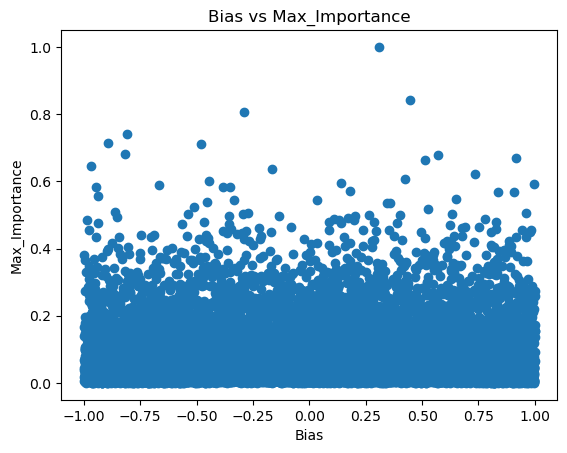

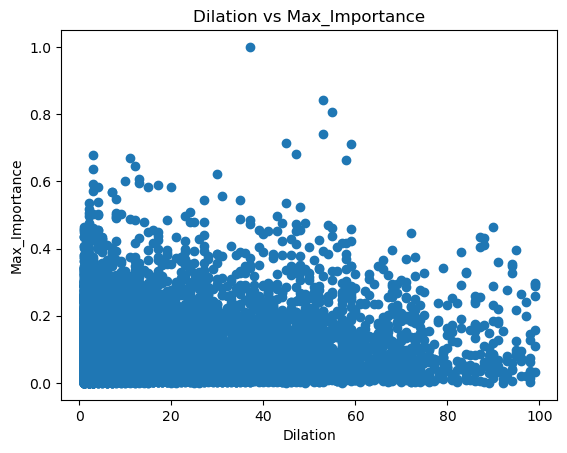

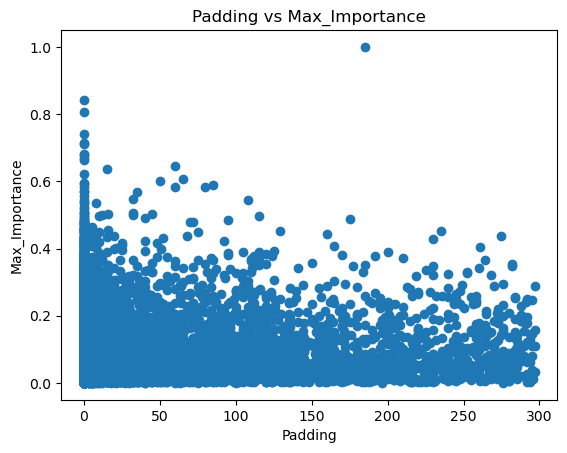

In [358]:
import matplotlib.pyplot as plt

# Assuming df_importance_all_kernels is your DataFrame containing the data
# Scatter plot for Bias vs Max_Importance
plt.scatter(df_importance_all_kernels['Bias'], df_importance_all_kernels['Max_Importance'])
plt.xlabel('Bias')
plt.ylabel('Max_Importance')
plt.title('Bias vs Max_Importance')
plt.show()


plt.scatter(df_importance_all_kernels['Dilation'], df_importance_all_kernels['Max_Importance'])
plt.xlabel('Dilation')
plt.ylabel('Max_Importance')
plt.title('Dilation vs Max_Importance')
plt.show()


plt.scatter(df_importance_all_kernels['Padding'], df_importance_all_kernels['Max_Importance'])
plt.xlabel('Padding')
plt.ylabel('Max_Importance')
plt.title('Padding vs Max_Importance')
plt.show()


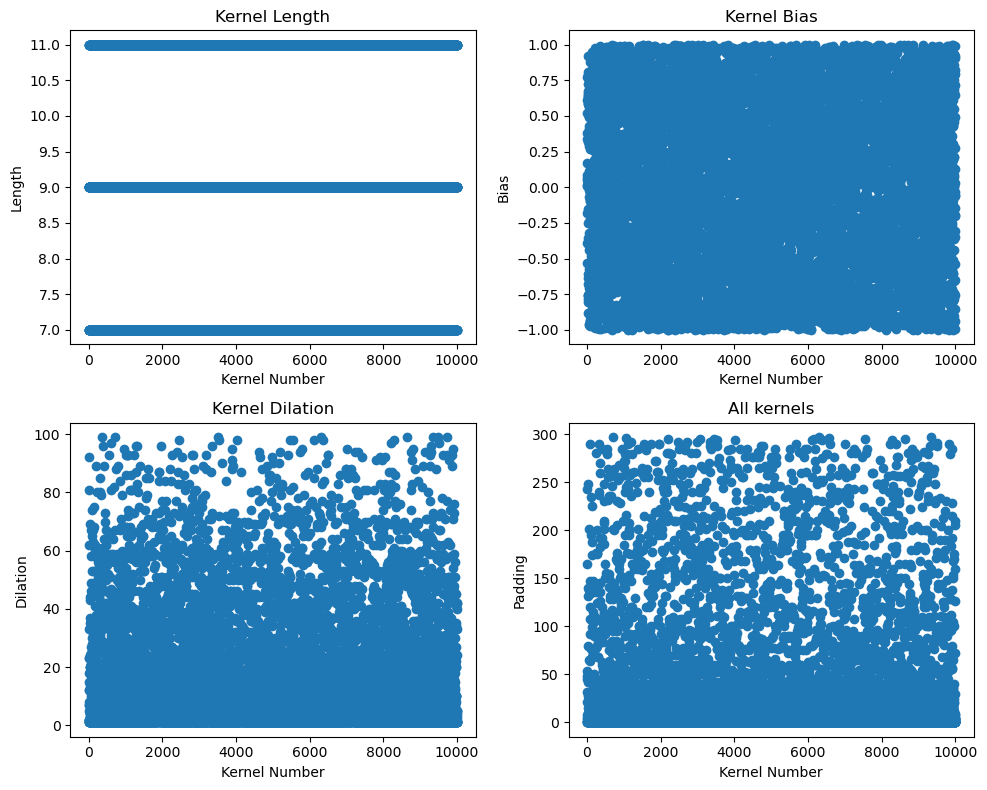

In [217]:
# Assuming kernel_info is a list containing dictionaries of kernel information
kernel_numbers = [kernel["Kernel"] for kernel in kernel_info]
kernel_lengths = [kernel["Length"] for kernel in kernel_info]
kernel_biases = [kernel["Bias"] for kernel in kernel_info]
kernel_dilations = [kernel["Dilation"] for kernel in kernel_info]
kernel_paddings = [kernel["Padding"] for kernel in kernel_info]

# Scatter plots
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.scatter(kernel_numbers, kernel_lengths)
plt.xlabel('Kernel Number')
plt.ylabel('Length')
plt.title('Kernel Length')

plt.subplot(2, 2, 2)
plt.scatter(kernel_numbers, kernel_biases)
plt.xlabel('Kernel Number')
plt.ylabel('Bias')
plt.title('Kernel Bias')

plt.subplot(2, 2, 3)
plt.scatter(kernel_numbers, kernel_dilations)
plt.xlabel('Kernel Number')
plt.ylabel('Dilation')
plt.title('Kernel Dilation')

plt.subplot(2, 2, 4)
plt.scatter(kernel_numbers, kernel_paddings)
plt.xlabel('Kernel Number')
plt.ylabel('Padding')
plt.title('Kernel Padding')

plt.tight_layout()
plt.title("All kernels")
plt.show()


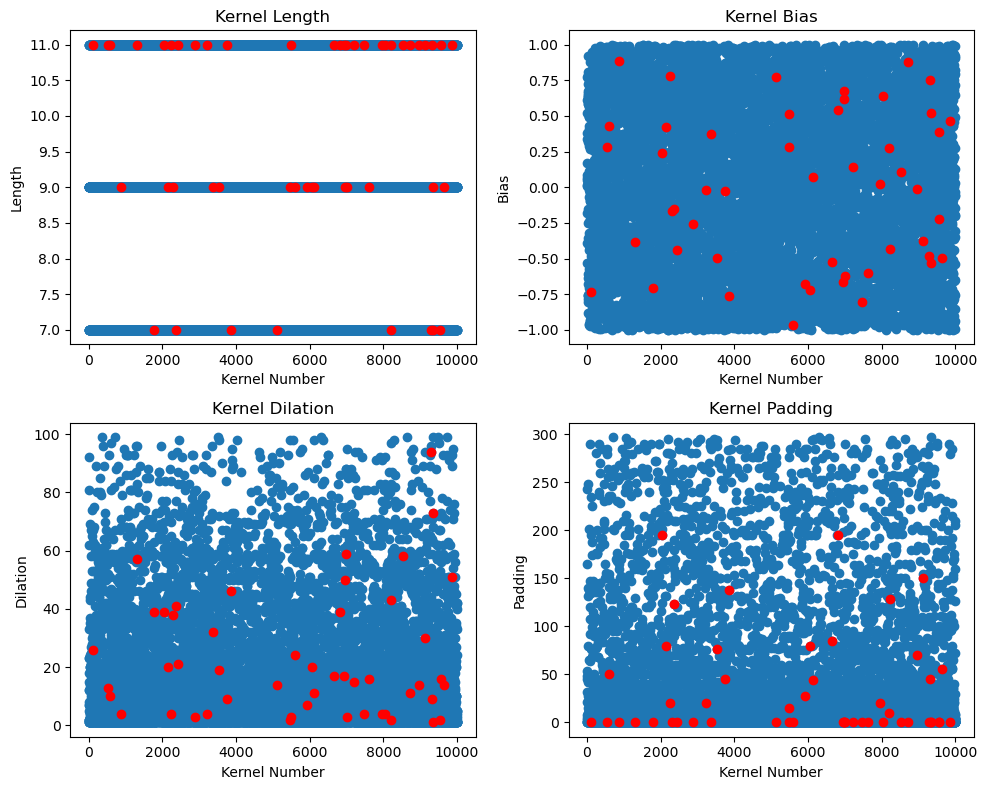

In [218]:
import matplotlib.pyplot as plt

# Assuming kernel_info is a list containing dictionaries of kernel information
kernel_numbers = [kernel["Kernel"] for kernel in kernel_info]
kernel_lengths = [kernel["Length"] for kernel in kernel_info]
kernel_biases = [kernel["Bias"] for kernel in kernel_info]
kernel_dilations = [kernel["Dilation"] for kernel in kernel_info]
kernel_paddings = [kernel["Padding"] for kernel in kernel_info]

# Red kernels
# red_kernel_numbers = [9199, 1590, 1993, 1329, 9225, 7569, 3683, 2506, 6771, 4017]  # Example red kernels
red_kernel_numbers = list(map(int, feature_index.tolist()))

# Scatter plots
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.scatter(kernel_numbers, kernel_lengths)
for red_kernel in red_kernel_numbers:
    if red_kernel in kernel_numbers:
        index = kernel_numbers.index(red_kernel)
        plt.scatter(red_kernel, kernel_lengths[index], color='red')
plt.xlabel('Kernel Number')
plt.ylabel('Length')
plt.title('Kernel Length')

plt.subplot(2, 2, 2)
plt.scatter(kernel_numbers, kernel_biases)
for red_kernel in red_kernel_numbers:
    if red_kernel in kernel_numbers:
        index = kernel_numbers.index(red_kernel)
        plt.scatter(red_kernel, kernel_biases[index], color='red')
plt.xlabel('Kernel Number')
plt.ylabel('Bias')
plt.title('Kernel Bias')

plt.subplot(2, 2, 3)
plt.scatter(kernel_numbers, kernel_dilations)
for red_kernel in red_kernel_numbers:
    if red_kernel in kernel_numbers:
        index = kernel_numbers.index(red_kernel)
        plt.scatter(red_kernel, kernel_dilations[index], color='red')
plt.xlabel('Kernel Number')
plt.ylabel('Dilation')
plt.title('Kernel Dilation')

plt.subplot(2, 2, 4)
plt.scatter(kernel_numbers, kernel_paddings)
for red_kernel in red_kernel_numbers:
    if red_kernel in kernel_numbers:
        index = kernel_numbers.index(red_kernel)
        plt.scatter(red_kernel, kernel_paddings[index], color='red')
plt.xlabel('Kernel Number')
plt.ylabel('Padding')
plt.title('Kernel Padding')

plt.tight_layout()
plt.show()


In [141]:
for _, i in feature_index.iteritems():
    print(kernel_info[int(i)-1])


{'Kernel': 9199, 'Weights': [0.3601251244544983, 0.7631769180297852, 0.25634661316871643, -0.5943488478660583, -0.987285852432251, 0.10975240170955658, -1.042963981628418, 0.6144341826438904, 0.683364987373352, -0.25206562876701355, 0.8747641444206238], 'Length': 11, 'Bias': 0.51119775, 'Dilation': 42, 'Padding': 0, 'Num_Channel_Indices': 2, 'Channel_Indices': [1, 0]}
{'Kernel': 1590, 'Weights': [-1.8650832176208496, 0.9290767312049866, 1.2034707069396973, -0.2112666517496109, -1.4919992685317993, 2.0052804946899414, -0.39482581615448, 0.04068934544920921, -0.17918460071086884, -0.9269480109214783, 0.3480454683303833], 'Length': 11, 'Bias': 0.8939007, 'Dilation': 41, 'Padding': 0, 'Num_Channel_Indices': 2, 'Channel_Indices': [1, 0]}
{'Kernel': 1993, 'Weights': [0.7412420511245728, -0.6318841576576233, 1.0809483528137207, 0.01605374552309513, -0.30320996046066284, 0.990045428276062, -0.7332152724266052, -0.3645034432411194, 1.4056657552719116], 'Length': 9, 'Bias': 0.10211168, 'Dilation

In [277]:
df_importance_all_kernels.dtypes

Kernel                   int64
Weights                 object
Length                   int32
Bias                   float32
Dilation                 int32
Padding                  int32
Num_Channel_Indices      int32
Channel_Indices         object
Max_Importance         float64
dtype: object

In [294]:
def pattern_to_string(pattern):
    return ','.join(map(str, pattern))

df_importance_all_kernels['Pattern_String_channel'] = df_importance_all_kernels['Channel_Indices'].apply(pattern_to_string)

In [299]:
df_importance_all_kernels["Pattern_String_channel"].unique()

array(['5,4,3', '2,5,1,3', '3,0,1', ..., '0,1,3,4,2', '3,1,5,2,0',
       '5,3,1,4,0'], dtype=object)

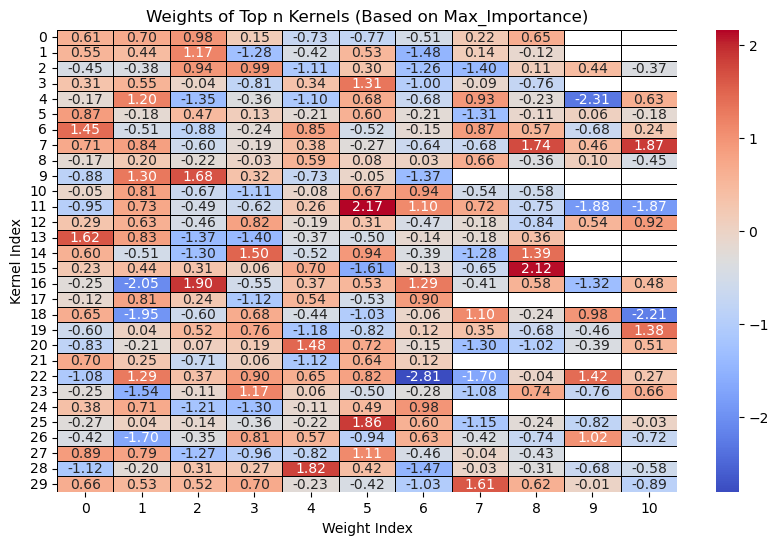

In [305]:
import seaborn as sns
top_10_kernels = df_importance_all_kernels.sort_values(by='Max_Importance', ascending=False).head(30)

top_10_kernels_weights = top_10_kernels['Weights']

max_length = top_10_kernels_weights.apply(len).max()

# truncate to same size
padded_weights = top_10_kernels_weights.apply(lambda x: np.pad(x, (0, max_length - len(x)), mode='constant', constant_values=np.nan))
padded_weights_array = np.array(padded_weights.tolist())

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(padded_weights_array, cmap='coolwarm', linewidths=0.5, linecolor='black', annot=True, fmt=".2f")
plt.xlabel('Weight Index')
plt.ylabel('Kernel Index')
plt.title('Weights of Top n Kernels (Based on Max_Importance)')
plt.show()


In [313]:
pattern_groups_data = df_importance_all_kernels.groupby("Pattern_String_channel").agg({'Max_Importance': 'median', 'Pattern_String_channel': 'count'})
pattern_groups_data.columns = ['Mean_Max_Importance', 'Frequency']

In [327]:
pattern_groups_data[pattern_groups_data["Frequency"]>5].sort_values(by='Mean_Max_Importance', ascending=True).head(100)

,Mean_Max_Importance,Frequency
Pattern_String_channel,,
4,0.010301,597
"4,3,0",0.015575,10
3,0.022340,580
"3,4",0.026525,64
"4,3",0.028927,62
...,...,...
"5,4,2",0.100842,12
"4,1,2",0.101080,15
"2,5,4",0.101257,9


(array([2., 2., 2., 0., 1., 1., 0., 1., 0., 1.]),
 array([0.61223686, 0.63814513, 0.66405341, 0.68996169, 0.71586997,
        0.74177825, 0.76768653, 0.79359481, 0.81950309, 0.84541137,
        0.87131965]),
 <BarContainer object of 10 artists>)

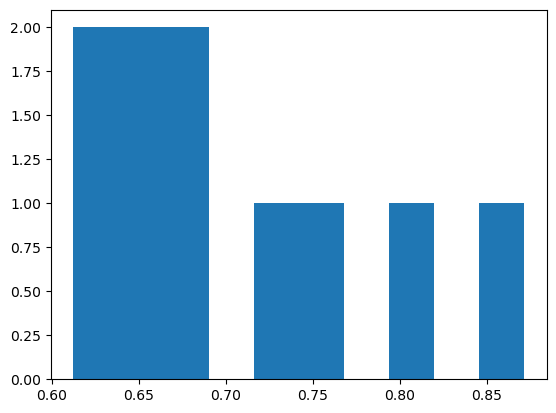

In [345]:
plt.hist(pattern_groups_data[pattern_groups_data["Mean_Max_Importance"]>=0.6]["Mean_Max_Importance"])

In [346]:
pattern_groups_data[pattern_groups_data["Mean_Max_Importance"]>=0.6]

,Mean_Max_Importance,Frequency
Pattern_String_channel,,
"0,4,1,2,5,3",0.612623,1
"0,5,1,2,3",0.639133,1
"1,0,4,2,5,3",0.871320,1
"2,0,4,1,3,5",0.812085,1
"3,2,4,0,1",0.642851,2
"3,5,1,0,2",0.737843,1
"3,5,4,0,1",0.752169,1
"4,1,2,3,5",0.612237,1
"4,2,5,0,1,3",0.685703,1


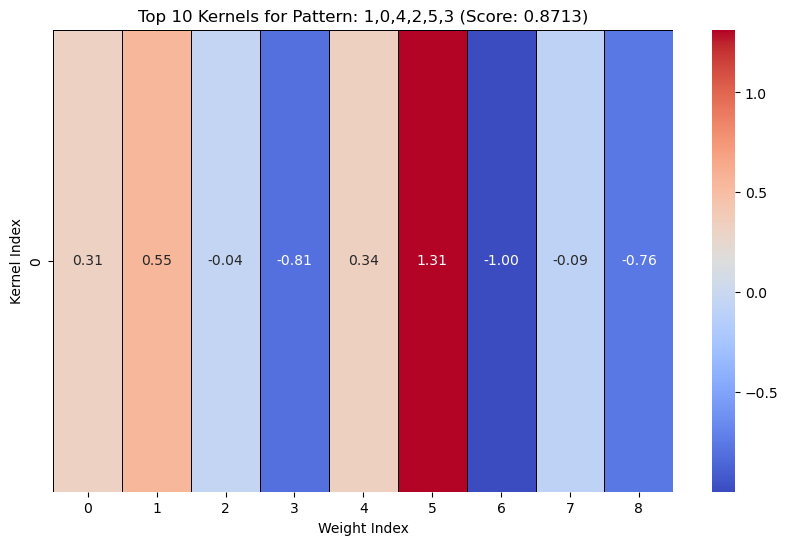

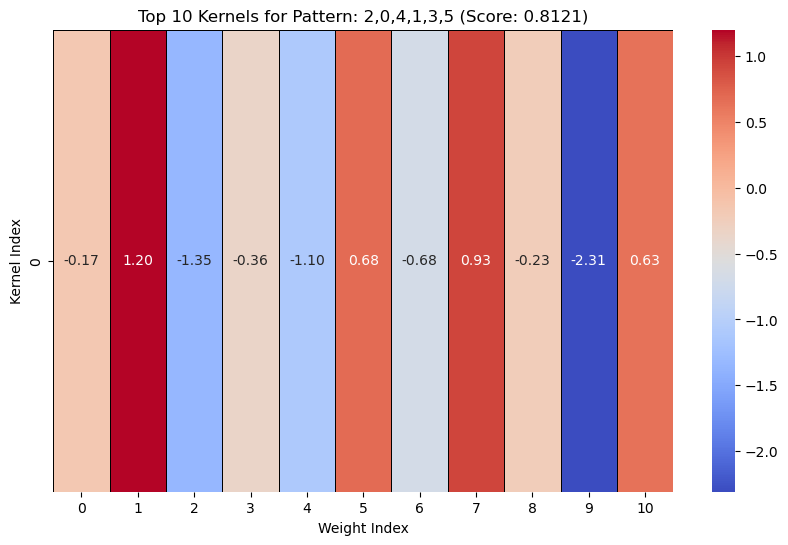

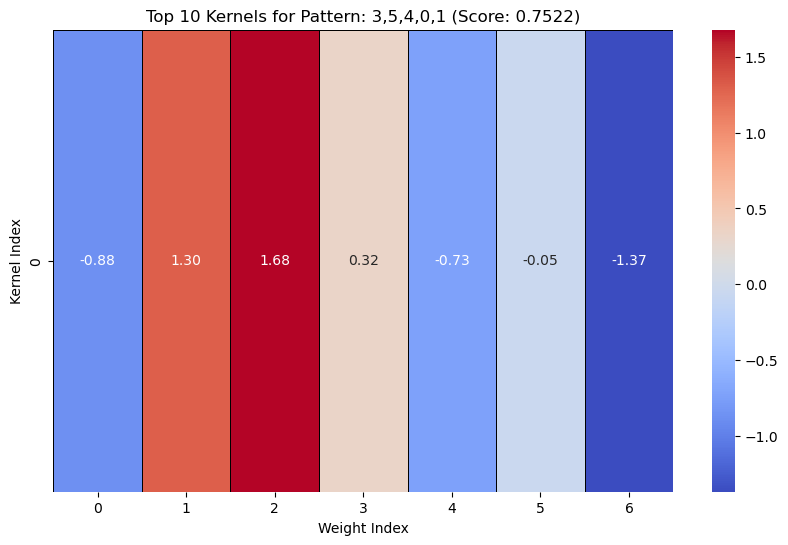

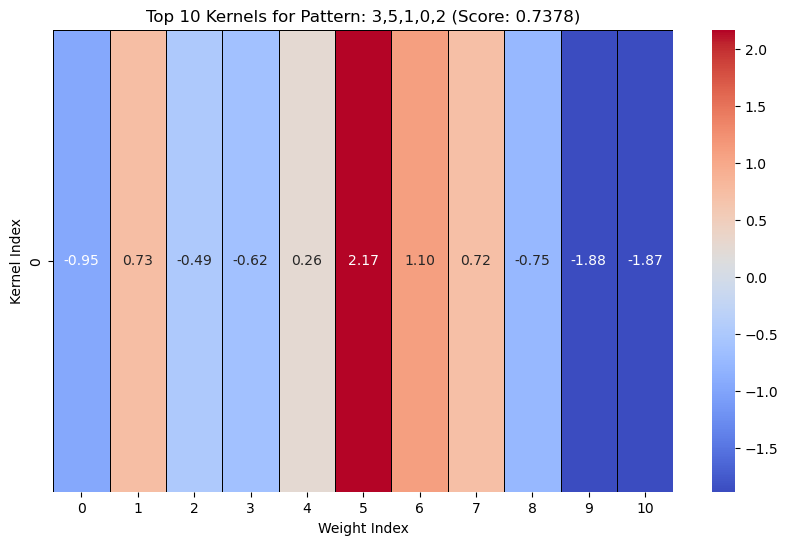

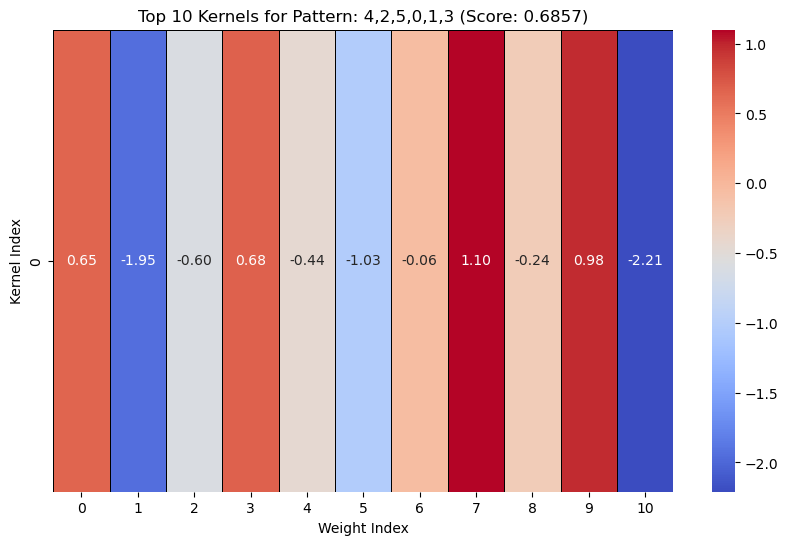

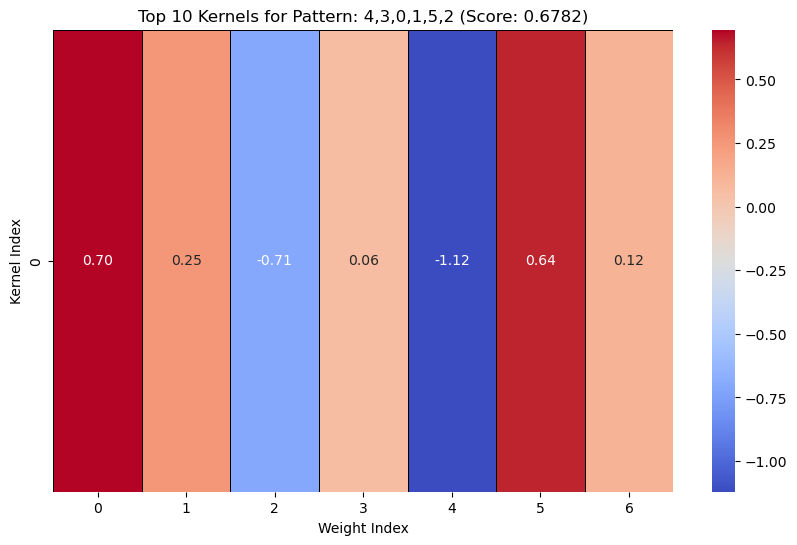

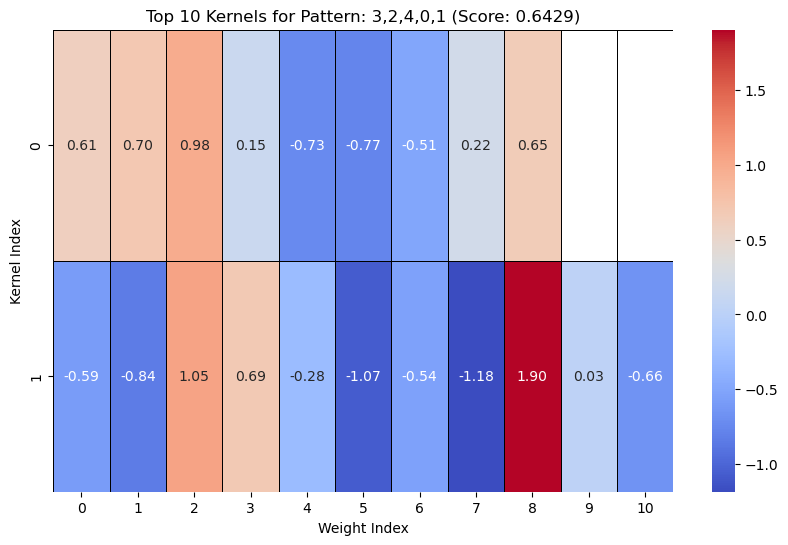

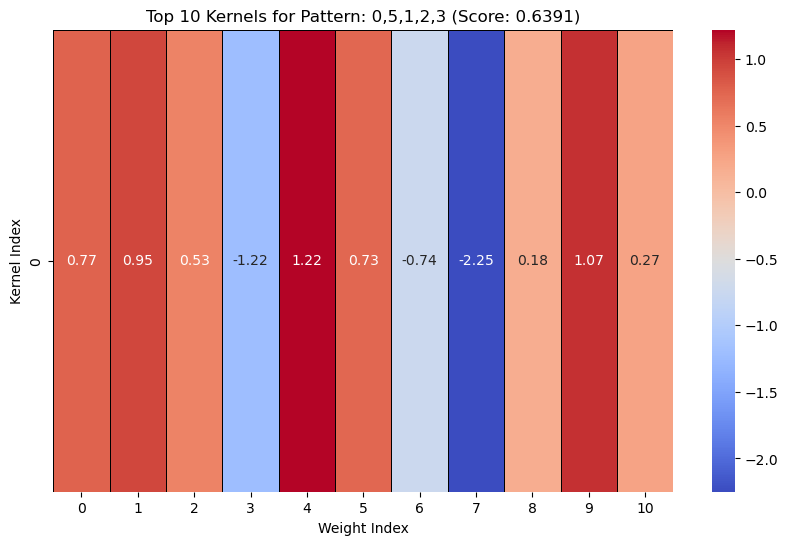

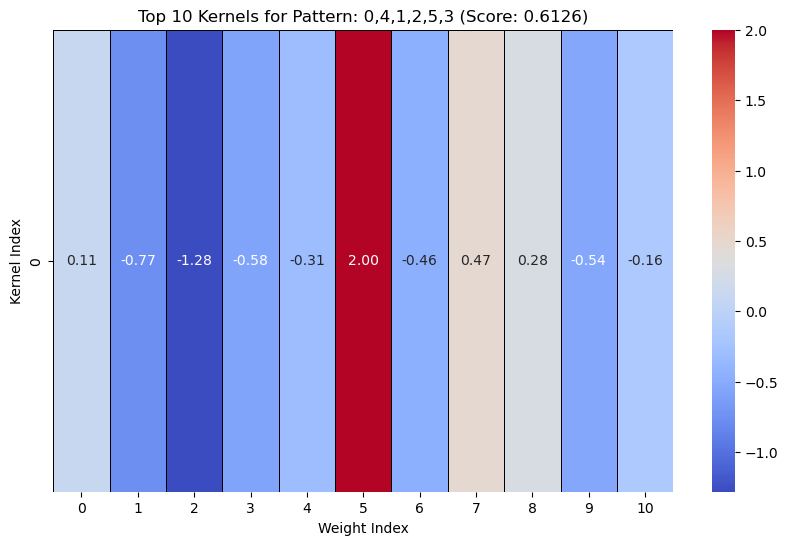

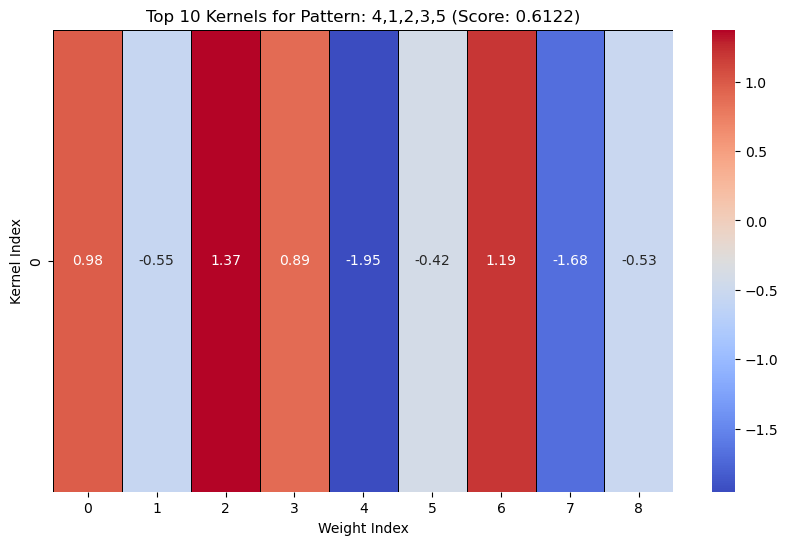

In [341]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_importance_all_kernels is your DataFrame

pattern_groups_data = df_importance_all_kernels.groupby("Pattern_String_channel").agg({'Max_Importance': 'median', 'Pattern_String_channel': 'count'})
pattern_groups_data.columns = ['Mean_Max_Importance', 'Frequency']

# Filter patterns with frequency > 5 and sort by mean max-importance
top_10_patterns = pattern_groups_data[pattern_groups_data["Frequency"] > 0].nlargest(10, 'Mean_Max_Importance')

# Plot top 10 kernels for each of the top 10 patterns
for pattern, score in zip(top_10_patterns.index, top_10_patterns['Mean_Max_Importance']):
    # Get the top 10 kernels for the current pattern
    top_10_kernels_pattern = df_importance_all_kernels[df_importance_all_kernels["Pattern_String_channel"] == pattern] \
        .nlargest(10, 'Max_Importance')
    
    # Check if there are kernels for this pattern
    if not top_10_kernels_pattern.empty:
        # Prepare data for heatmap
        top_10_kernels_weights = top_10_kernels_pattern['Weights']
        max_length = top_10_kernels_weights.apply(len).max()
        padded_weights = top_10_kernels_weights.apply(lambda x: np.pad(x, (0, max_length - len(x)), mode='constant', constant_values=np.nan))
        padded_weights_array = np.array(padded_weights.tolist())
        
        # Plot the heatmap
        plt.figure(figsize=(10, 6))
        sns.heatmap(padded_weights_array, cmap='coolwarm', linewidths=0.5, linecolor='black', annot=True, fmt=".2f")
        plt.xlabel('Weight Index')
        plt.ylabel('Kernel Index')
        plt.title(f'Top 10 Kernels for Pattern: {pattern} (Score: {score:.4f})')
        plt.show()
    else:
        print(f"No kernels found for pattern: {pattern} (Score: {score:.4f})")


In [335]:
top_10_kernels_pattern["Max_Importance"]

2430    0.691305
1868    0.396320
8352    0.316317
5423    0.296548
7370    0.070423
8171    0.041711
4883    0.009879
Name: Max_Importance, dtype: float64